# LDA model using gensim

In [19]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

[nltk_data] Downloading package stopwords to /home/gpu1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
len(STOP_WORDS)

305

In [21]:
#punctuations = string.punctuation
stop_words = list(STOP_WORDS)

## Read file 

In [22]:
# reviews = pd.read_excel('../data/Bag_Reviews.xlsx')
reviews = pd.read_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/input/amazon_cloth_shoe_watches_reviews_with_title.csv')
reviews['comments'] = reviews.comments.astype('str')
# reviews = reviews[['rating','comments']]
reviews.head()

,comments,rating,asin,brand,title,categories
0,Perfect red tutu for the price. I baught it as...,5.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
1,This was a really cute tutu the only problem i...,4.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
2,the tutu color was very nice. the only issue w...,2.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
3,My 3-yr-old daughter received this as a gift f...,1.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
4,Bought it for my daughters first birthday whic...,4.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."


### Remove emails and newline characters

In [23]:
# Convert to list
data = reviews.comments.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['Perfect red tutu for the price. I baught it as part of my daughters Halloween costume and it looked great on her.']


### Tokenize words and Clean-up text

In [24]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['perfect', 'red', 'tutu', 'for', 'the', 'price', 'baught', 'it', 'as', 'part', 'of', 'my', 'daughters', 'halloween', 'costume', 'and', 'it', 'looked', 'great', 'on', 'her']]


### Creating Bigram and Trigram Models

In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=4, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[2000]]])

['cannot_say', 'how_much', 'love', 'this', 'player', 'from', 'creative', 'it', 'has', 'tons_of', 'features', 'some', 'youll_probably', 'never', 'use', 'like', 'the', 'eax', 'processing', 'and', 'gb', 'of', 'storage', 'it', 'also', 'has', 'an', 'easy', 'to', 'navigate', 'menu', 'with', 'two', 'settings', 'one', 'for', 'novices', 'and', 'one', 'for', 'advanced', 'users', 'in_terms_of', 'sound', 'quality', 'the', 'freq', 'response', 'is', 'fairly', 'nice', 'for', 'this', 'type', 'of', 'player', 'and', 'the', 'signal', 'to', 'noise', 'ratio', 'is', 'above', 'most', 'of', 'the', 'mp', 'have', 'gt', 'db', 'the', 'unit', 'is', 'also', 'only', 'the', 'size', 'of', 'normal', 'cd_player', 'which', 'is', 'nice', 'compared', 'to', 'some', 'of', 'the', 'huge', 'bulky', 'models', 'like', 'archos', 'models', 'the', 'only_reason', 'that', 'gave', 'the', 'nomad', 'stars', 'is', 'because', 'of', 'the', 'usb_port', 'too', 'slow', 'and', 'the', 'limited', 'battery_life', 'its', 'nice', 'that', 'creative',

In [8]:
bigram_mod

### Remove Stopwords, Make Bigrams and Lemmatize


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['perfect', 'red', 'tutu', 'price', 'baught', 'daughter', 'halloween', 'costume', 'look', 'great']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [15]:
id2word[0]

'baught'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('baught', 1),
  ('costume', 1),
  ('daughter', 1),
  ('great', 1),
  ('halloween', 1),
  ('look', 1),
  ('perfect', 1),
  ('price', 1),
  ('red', 1),
  ('tutu', 1)]]

## Building the Topic Model

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=46,
                                           update_every=1,
                                           chunksize=10,
                                           passes=50,
                                           alpha=.001,#'auto',
                                           per_word_topics=True,
                                           eta=.001
                                           )

### View the topics in LDA model

In [18]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.191*"not" + 0.133*"look" + 0.111*"be" + 0.107*"do" + 0.093*"find" + '
  '0.086*"amazon" + 0.069*"love" + 0.063*"get" + 0.045*"comfortable" + '
  '0.036*"big"'),
 (1,
  '0.258*"order" + 0.143*"try" + 0.069*"tight" + 0.064*"s" + 0.056*"like" + '
  '0.052*"receive" + 0.049*"send" + 0.044*"company" + 0.037*"would" + '
  '0.033*"cost"'),
 (2,
  '0.176*"fit" + 0.092*"buy" + 0.076*"wear" + 0.073*"good" + 0.049*"year" + '
  '0.048*"color" + 0.043*"great" + 0.041*"quality" + 0.038*"time" + '
  '0.028*"price"'),
 (3,
  '0.463*"problem" + 0.410*"short" + 0.093*"super" + 0.029*"cute" + '
  '0.000*"wgere" + 0.000*"infinite" + 0.000*"goodfabric" + 0.000*"biy" + '
  '0.000*"tightdoe" + 0.000*"anyday"')]


### Compute Model Perplexity and Coherence Score

In [75]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.974362327331873

Coherence Score:  0.48568661254146006


## Visualize the topics-keywords

In [76]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/gpu1/anaconda3/envs/fastaipy372/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.404013  0.015383       1        1  36.300163
1     -0.127271 -0.308139       2        1  30.644638
3     -0.154057  0.303295       3        1  25.235256
0     -0.122685 -0.010539       4        1   7.819942, topic_info=     Category         Freq                 Term        Total  loglift  logprob
23    Default  5372.000000                 good  5372.000000  30.0000  30.0000
45    Default  3565.000000              product  3565.000000  29.0000  29.0000
2     Default  1966.000000                price  1966.000000  28.0000  28.0000
181   Default   698.000000                 reed   698.000000  27.0000  27.0000
112   Default  1709.000000              quality  1709.000000  26.0000  26.0000
99    Default  1366.000000             delivery  1366.000000  25.0000  25.0000
158   Default  1192.000000                 fast  1192.000000  24.0000  24.0000
91    Default  1146.000000                value  1146.000000  23.0000  23.0000
341   Default   387.000000                  œðy   387.000000  22.0000  22.0000
55    Default   661.000000            beautiful   661.000000  21.0000  21.0000
7     Default   554.000000                  bag   554.000000  20.0000  20.0000
523   Default   521.000000           reasonable   521.000000  19.0000  19.0000
166   Default   684.000000              service   684.000000  18.0000  18.0000
46    Default   582.000000              receive   582.000000  17.0000  17.0000
50    Default   559.000000                 shop   559.000000  16.0000  16.0000
19    Default   448.000000                worth   448.000000  15.0000  15.0000
1     Default   476.000000                order   476.000000  14.0000  14.0000
84    Default   371.000000                cheap   371.000000  13.0000  13.0000
62    Default   326.000000                   mm   326.000000  12.0000  12.0000
376   Default   327.000000              deliver   327.000000  11.0000  11.0000
0     Default   273.000000                 baht   273.000000  10.0000  10.0000
21    Default   245.000000                 cute   245.000000   9.0000   9.0000
293   Default   327.000000                 pack   327.000000   8.0000   8.0000
68    Default   216.000000                  buy   216.000000   7.0000   7.0000
44    Default   250.000000                money   250.000000   6.0000   6.0000
83    Default   110.000000                 nice   110.000000   5.0000   5.0000
43    Default   102.000000                 item   102.000000   4.0000   4.0000
228   Default    97.000000                  day    97.000000   3.0000   3.0000
378   Default   214.000000              picture   214.000000   2.0000   2.0000
116   Default   211.000000                  not   211.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ...
266    Topic4    91.665421                 best    93.849731   2.5249  -3.5028
202    Topic4    21.526726                   ²a    22.308916   2.5128  -4.9517
1583   Topic4    79.808754              amc_amc    82.978096   2.5095  -3.6413
847    Topic4    30.793221                  ¼ðy    32.161919   2.5050  -4.5937
623    Topic4    28.792706              confuse    30.086308   2.5045  -4.6609
856    Topic4    19.106203               person    19.986607   2.5034  -5.0710
236    Topic4    50.242020                  pay    52.806255   2.4987  -4.1041
127    Topic4    26.055143                 help    27.416920   2.4975  -4.7608
1008   Topic4    24.290304                  eat    25.627151   2.4949  -4.8309
882    Topic4    24.148916  financial_statement    25.600027   2.4901  -4.8367
466    Topic4    19.612373                   go    20.837107   2.4879  -5.0448
946    Topic4    16.170979                  non    17.393492   2.4756  -5.2378
568    Topic4    12.912466             pleasing    13.978142   2.4692  -5.4628
389    Topic4     8.988540                press     9.743329   2.4679  -5.8250

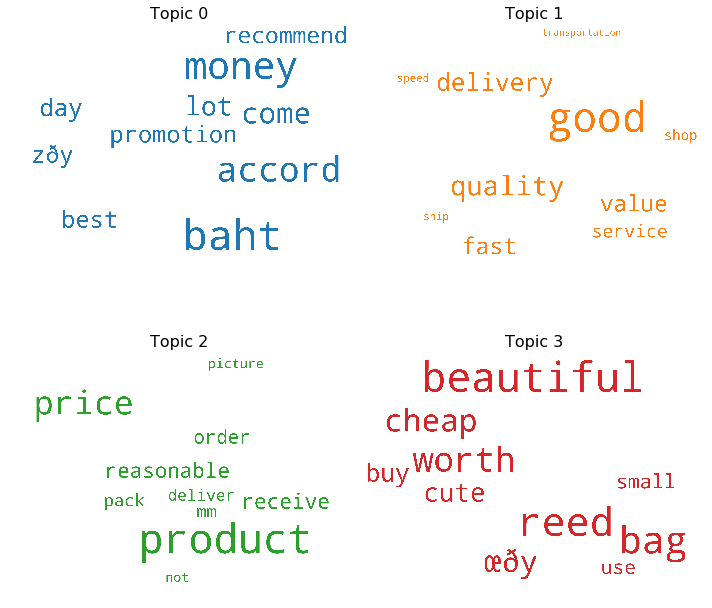

In [80]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOP_WORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#  Building LDA Mallet Model

In [61]:
SOME_FIXED_SEED = 47

# before training/inference:
np.random.seed(SOME_FIXED_SEED)

NUM_TOPICS = 4
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word,random_seed=47)

In [62]:
ldamallet.random_seed

47

In [63]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v',)
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('good', 0.5995216306156406),
   ('quality', 0.16399750415973377),
   ('service', 0.0680116472545757),
   ('lot', 0.021110648918469217),
   ('company', 0.018406821963394344),
   ('ship', 0.017990848585690517),
   ('speed', 0.017366888519134774),
   ('transportation', 0.015183028286189684),
   ('store', 0.013831114808652246),
   ('provide', 0.010295341098169717)]),
 (1,
  [('product', 0.3378995433789954),
   ('delivery', 0.16766186629200328),
   ('fast', 0.12457557663037115),
   ('œðy', 0.058189907504976),
   ('receive', 0.05081372204659876),
   ('ƒðy', 0.025055614096709988),
   ('pack', 0.018967334035827187),
   ('complete', 0.01510361784334387),
   ('ðyz', 0.014635288607891348),
   ('long', 0.013932794754712563)]),
 (2,
  [('beautiful', 0.0956430568499534),
   ('order', 0.07840167753960857),
   ('bag', 0.0603448275862069),
   ('zðy', 0.06022833178005592),
   ('shop', 0.05964585274930102),
   ('reed', 0.04904473438956197),
   ('color', 0.045083876980428705),
   ('cute', 0.03949

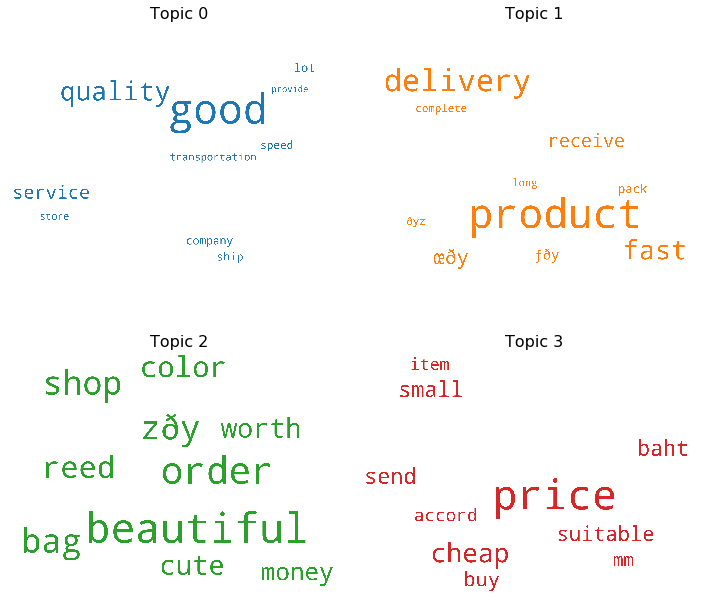

In [64]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOP_WORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [35]:
topics_lda = ldamallet.show_topics(formatted=False)
topics_lda_df  = pd.DataFrame()
i1 = [ t[0] for t in topics_lda]
i2 = []
for t in topics_lda:
    for t1 in t[1]:
        i2.append(t1[0])
        
topics_lda_df['topic'] = i1
for i in i2:
    topics_lda_df[i] = 0.0

for i,t in enumerate(topics_lda):
    for t1 in t[1]:
        topics_lda_df.loc[topics_lda_df.topic==i,t1[0]]=t1[1]

In [36]:
topics_lda_df

,topic,order,zðy,shop,color,send,buy,lot,accord,item,...,price,beautiful,bag,œðy,cheap,cute,worth,small,baht,suitable
0,0,0.079466,0.061046,0.060456,0.045696,0.03377,0.028221,0.02397,0.021254,0.018656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.180966,0.095056,0.059975,0.057543,0.050017,0.03925,0.038092,0.032998,0.032187,0.028945


In [66]:
def preprocess(doc):
    
    data = [doc]

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=4, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Corpus
    texts = data_lemmatized
    
    return texts

In [72]:
doc = "worth price"
doc = preprocess(doc)
#bow = corpora.dictionary.doc2bow(utils.simple_preprocess(doc))
bow = [id2word.doc2bow(d) for d in doc]
pprint(ldamallet[bow])

[[(0, 0.2403846153846154),
  (1, 0.2403846153846154),
  (2, 0.25961538461538464),
  (3, 0.25961538461538464)]]
